The goal of this notebook is to determine if it is possible to find the correct signal above another as a function of its amplitude. The distances of the merger that is added is changed in order to change its amplitude. We then keep track of the number of SNRS found at the correct time (for 3500 possible) as a function of the apltiude ratio. 

In [1]:
import numpy as np

distances = np.arange(500, 3600, 100)
#distances = [500, 1000, 6000]


In [2]:
# beautiful plots
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
from pycbc.catalog import Merger
from pycbc.filter import matched_filter
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.psd import inverse_spectrum_truncation, interpolate
import numpy

In [4]:
#make the strain
merger = Merger("GW170814")
strain = merger.strain('L1')

In [5]:
#fct to build the template

def gen_template(theta,
                 delta_t=strain.delta_t,
                 duration=strain.duration,
                 start_time=strain.start_time,
                 f_lower=20):
    
    m1, m2, distance, inclination, time, phase = theta

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             spin1z=-0.568797,
                             spin2z=0.13079314,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    # Resize the signal buffer, and shift to the requested time
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - strain.start_time)
    hp.start_time = strain.start_time

    return hp

In [6]:
params = [31.1241027, 25.0041171, 1235.73083, 4.20243494e-08, 
          1.18674186e+09, -3.77985234e-01]
best_fit_template = gen_template(params)

In [7]:
ind = best_fit_template.numpy().argmax()
max_val = best_fit_template[ind]

print(max_val)

5.2694595814500845e-22


In [16]:
time_shifts = np.arange(0, 32, 0.1)
snrps = [[] for i in range(len(distances))]
times_snr=[[] for i in range(len(distances))]
snrs = []

samples = [None for i in range(len(distances))]

for i in range(len(samples)):
    samples[i] = [0,0,0]

amp_ratio = [0 for i in range(len(distances))]
i = 0
for dist in distances:
    print("Distance: %i" %dist)
    for t in range(len(time_shifts)):
        #build the template needed
        hp, hf = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 45.,
                        mass2 = 50., delta_t = strain.delta_t, 
                        distance = dist,f_lower = 15.)
        hp.resize(len(strain))
        hp = hp.cyclic_time_shift(+time_shifts[t])
        hp.start_time = strain.start_time
        
        ind = hp.numpy().argmax()
        max_amp = hp[ind]
        time_ev = hp.sample_times[ind]
        time_diff = time_ev - merger.time
        
        ratio = float(max_amp)/max_val

        amp_ratio[i] = ratio
        
        #make signal
        signal = strain + hp
        
        #build the psd
        p = signal.psd(2)
        p = interpolate(p, signal.delta_f)
        psd = inverse_spectrum_truncation(p, 2*signal.sample_rate, 
                                     low_frequency_cutoff = 15.)
        
        #build the template
        temp_hp, temp_hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=signal.delta_f, f_final=739.0645)
    
        temp_hp.resize(len(psd))
        template = temp_hp.cyclic_time_shift(temp_hp.start_time)
        
        #compute snr
        snr = matched_filter(template, signal, psd = psd, 
                         low_frequency_cutoff = 20.)
        snr = snr.crop(1,1)
        indx = abs(snr).numpy().argmax()
        snrp = abs(snr)[indx]
        snrps[i].append(snrp)
        time_snr = snr.sample_times[indx]
        times_snr[i].append(time_snr)
        if t == 12:
            snrs.append(snr)
        
        #collect the samples
        
        if (abs(time_snr - merger.time) < 0.1):
            samples[i][0] += 1
        elif (abs(time_snr - time_snr) < 0.1):
            samples[i][1] += 1
        else:
            samples[i][2] +=1 
    i += 1
    print("Done")
        
        

Distance: 500
Done
Distance: 600
Done
Distance: 700
Done
Distance: 800
Done
Distance: 900
Done
Distance: 1000
Done
Distance: 1100
Done
Distance: 1200
Done
Distance: 1300
Done
Distance: 1400
Done
Distance: 1500
Done
Distance: 1600
Done
Distance: 1700
Done
Distance: 1800
Done
Distance: 1900
Done
Distance: 2000
Done
Distance: 2100
Done
Distance: 2200
Done
Distance: 2300
Done
Distance: 2400
Done
Distance: 2500
Done
Distance: 2600
Done
Distance: 2700
Done
Distance: 2800
Done
Distance: 2900
Done
Distance: 3000
Done
Distance: 3100
Done
Distance: 3200
Done
Distance: 3300
Done
Distance: 3400
Done
Distance: 3500
Done


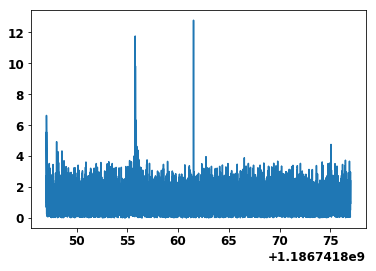

In [17]:
plt.plot(snrs[30].sample_times, abs(snrs[30]))

In [18]:
proportions_tmerg = [0 for i in range(len(samples))]
proportions_tinj = [0 for i in range(len(samples))]
proportions_others = [0 for i in range(len(samples))]


for i in range(len(samples)):
    proportions_tmerg[i] = (float(samples[i][0])/ (samples[i][0]+samples[i][1]+samples[i][2]))
    proportions_tinj[i] = (float(samples[i][1])/ (samples[i][0]+samples[i][1]+samples[i][2]))
    proportions_others[i] = (float(samples[i][2])/ (samples[i][0]+samples[i][1]+samples[i][2]))
                           

In [19]:
# beautiful plots
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [20]:
print(proportions_tmerg)

[0.06875, 0.06875, 0.06875, 0.06875, 0.06875, 0.071875, 0.096875, 0.284375, 0.671875, 0.896875, 0.959375, 0.98125, 0.9875, 0.990625, 0.990625, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.99375, 0.996875, 0.996875, 0.996875, 0.996875, 0.996875, 0.996875, 0.996875, 0.996875, 0.996875, 0.996875]


([<matplotlib.axis.XTick at 0x7fb4701124d0>,
 <a list of 5 Text xticklabel objects>)

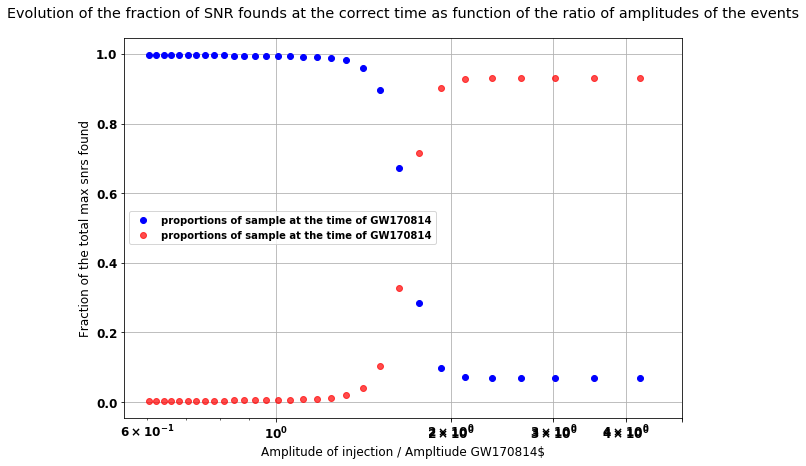

In [27]:
plt.figure(figsize = [10,7])

plt.plot(amp_ratio, proportions_tmerg, 'ob', label = 'proportions of sample at the time of GW170814')
plt.plot(amp_ratio, proportions_tinj, 'or', alpha = 0.7, label = 'proportions of sample at the time of GW170814')
#plt.plot(amp_ratio, proportions_others, 'og', alpha = 0.7, label = 'porpotions of samples at other times')

plt.legend(loc = 'center left',  prop={'size': 10})
plt.title("Evolution of the fraction of SNR founds at the correct time as function of the ratio of amplitudes of the events", pad = 20)
plt.grid()
plt.xlabel("Amplitude of injection / Ampltiude GW170814$")
plt.ylabel("Fraction of the total max snrs found")
plt.xscale('log')
plt.xticks([i for i in range(1,6,1)])

In [22]:
print(snrps)

[[12.672690392206697, 12.661107861952383, 36.460979143119594, 29.80389424429088, 32.69259971554929, 30.887269305215963, 31.794071342031526, 31.069534948804478, 30.109010140415183, 31.280358377531957, 31.601149286991387, 32.50014944801663, 31.70910989289224, 29.909393183038834, 30.238603975468873, 31.47208509425067, 30.79444492274595, 29.95623631508464, 31.70458045760592, 32.797058392886406, 31.669051854019266, 32.26726387022979, 29.35468516900505, 31.583830269235857, 30.759629754683626, 31.179519219947647, 32.78976864523664, 30.901313386209143, 29.452284933002456, 30.098374932790954, 32.39676261960652, 30.921070843087843, 31.642603110839467, 31.30130725493845, 33.386286117666856, 31.517215889418175, 31.05349721788644, 32.11821605299489, 30.464449714283084, 31.625145850060644, 32.39650799486217, 29.304875124667536, 32.014049618735264, 30.560995515522784, 31.799923765294334, 31.24889894036351, 31.852822384289517, 31.070252266508383, 31.76708423405255, 31.305481369967737, 31.2072762090406